In [146]:
import matplotlib.pyplot as plt
import numpy as np
from math import *
from scipy.optimize import curve_fit

In [133]:
countrateData = np.loadtxt("./../data/countRate_vs_threshold.txt", delimiter=",", skiprows=1)

countrateDictionary = {
    "threshold": countrateData[:,0],
    "counts": countrateData[:,1],
    "time": countrateData[:,2]
}

rates = []
for count, time in zip (countrateDictionary["counts"], countrateDictionary["time"]):
    rates.append(count / time)

countrateDictionary["rates"] = rates

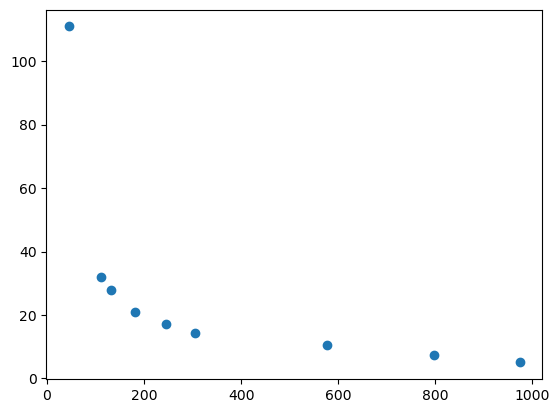

In [134]:
plt.scatter(countrateDictionary["threshold"], countrateDictionary["rates"])

In [215]:
def LoadExperimentRun(path, numberOfChannelsToRemove):
    binCounts = np.loadtxt(path)[numberOfChannelsToRemove:-1]

    binNumber = np.arange(numberOfChannelsToRemove, len(binCounts))

    return (binNumber, binCounts)

In [227]:
# Data Analysis pipeline

def RebinData(data, binFraction, method="mean"):
    # Inputs are the data output from LoadExperimentRun, and a binFraction which is a number between 0 and 1 which determines how large the bins are

    bins = list(data[0])
    data = list(data[1])

    binWidth = len(data) * binFraction

    lowerBound = bins[0]
    numberOfBins = floor(len(data) / binWidth)

    newBins = np.arange(lowerBound, binWidth * (numberOfBins + 1), binWidth)
    newBins = [floor(el) for el in newBins]

    #topBound = floor(newBins[-1] + binWidth)
    #newBins.append(topBound)
    
    binnedData = []

    for i, binBound in enumerate(newBins):
        #print(f"{i}/{len(newBins)}")
        if i < len(newBins)-1:
            binnedData.append(list(data[newBins[i]:newBins[i+1]]))

    # binnedData is a an array which each row containing a bin
    binnedData = np.array(binnedData, dtype="object")

    averagedBinnedData = []
    binnedDataUncertainty = []
    for row in binnedData:
        avg = AverageDataInBin(row, method)
        averagedBinnedData.append(avg[0])
        binnedDataUncertainty.append(avg[1])

    return (newBins[:-1], averagedBinnedData, binnedDataUncertainty)
    
def AverageDataInBin(dataInBin, method="mean"):

    if method == "mean":
        averagedRow = sum(dataInBin) / len(dataInBin)
        uncertainty = np.std(dataInBin)

    return averagedRow, uncertainty

def FindFitParameters(data, FittingFunction):

    pars, cov = curve_fit(FittingFunction, data[0], data[1], [2, -0.001, 0.1, 0.1])

    return pars, cov
    
def ExponentialCurve(x, a, b, c, d):
    y = []
    
    for point in x:
        y.append(a * exp(b * point + c) + d)
    
    return y

Text(0, 0.5, 'Counts')

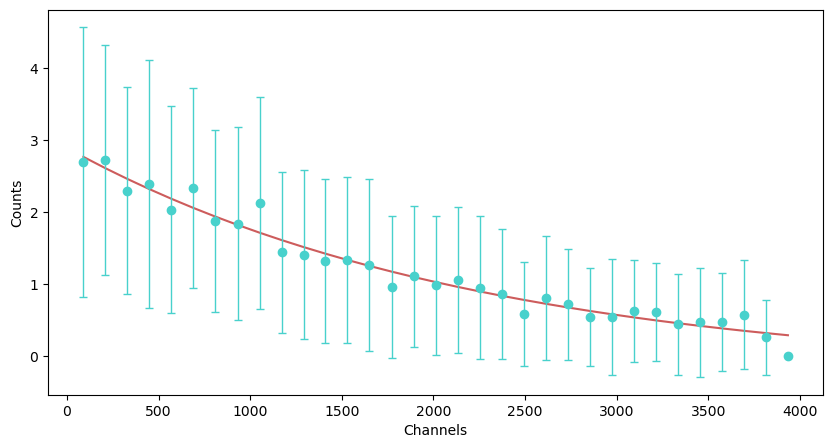

In [249]:
data = LoadExperimentRun("./../data/muons_T-800mV_W-40ns_DMH_75600s.txt", 90)

rebinnedData = RebinData(data, 0.03)

pars, cov = FindFitParameters(rebinnedData, ExponentialCurve)


fig, ax = plt.subplots(1, 1, figsize=(10,5))

#ax.scatter(rebinnedData[0], ExponentialCurve(rebinnedData[0], 2, -0.001, 0.1, 0.1), color="indianred")
ax.plot(rebinnedData[0], ExponentialCurve(rebinnedData[0], pars[0], pars[1], pars[2], pars[3]), color="indianred")

ax.errorbar(rebinnedData[0], rebinnedData[1], yerr=rebinnedData[2], fmt="o", capsize=3, linewidth=1, color="mediumturquoise")
ax.set_xlabel("Channels")
ax.set_ylabel("Counts")